# <b>Wikipedia Article Recommendation system


Authors:
- Martyna Stasiak id.156071
- Maria Musiał id.156062

----

### <b>Introduction</b>
The aim of this project is to implement a recommendation system to suggest similiar Wikipedia articles based on the ones that user have seen - user's history. <br>
The system first creates a database containing <b>1000</b> wikipedia articles by crawling starting from the link provided by the user, then preprocesses them and computes similarities to generate miningful and useful for user recommendations.

#### <b>Objectives</b>
1. <b>Crawling and Scraping</b> - collect at least a 1000 Wikipedia articles 
2. <b>Preprocessing</b> - process and clean the data so that it will be suitable for the recommendation, including stemming, lemmatization
3. <b>Similaries</b> - compute the similarities between articles in user's history and in the database
4. <b>Recomendations</b> - recommend the best matching articles to the ones in the user's history 
<br> <br>

#### <b>Additional steps</b>
1. <b>Crating recommendations for unknown articles</b> - user may have in their history some article that is not in our database, for that we expand the database by that article</b>
2. <b>Expanding the database</b> - for each unknown article we crawl other articles to get some miningful recommendations
<br> <br>

---------

Libraries used in this project:

In [91]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine

from IPython.core.display import display, HTML

import random 
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mmart\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mmart\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mmart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\mmart\AppData\Local\Temp\ipykernel_14736\2306764509.py:21: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### <b>Crawling and saving our articles</b>
In this part the csv file is created. It will work as a database containing wikipedia articles that may be recommended to the user.<br><br>
It is done by crawling, that starts from some given URL; here we have chosen https://en.wikipedia.org/wiki/Machine_learning that is the article about Machine Learning. However it might be simply changed by providing a different link while invoking the function.<br><br>
The `crawlArticles` function systematically collects articles by 'jumping' links found on Wikipedia pages. <br><br>
<b>It fetches the title, link, and main content</b> of each article while filtering out irrelevant or special pages (like, disambiguation pages, main page, and links with special characters like ':'). <br><br>
The function stores this information in a structured way, ensuring no duplicate visits, and includes a delay between requests to avoid overloading the server as it is requested by Wikipedia.<br><br> 

#### Structure of the csv file:<br>
The csv files contains max_articles number of them defined by us while invoking the function; for the purpose of the project and rather quick execution of the code we chose that our database called articles.csv will contain 1000 articles. <br>
Each row of the file corresponds to a one article; each of them is described by:
1. Title,
2. Link
3. Content <br><br>


A couple of cells below the collected articles are saved as a CSV file, using custom saving function that is used throughout the project, forming our base dataset for the recommendations.

In [92]:
def crawlArticles(start_url, max_articles):
    visited = set() # set of visited pages to keep the ones that have already been crawled
    to_visit = [start_url] # a list of pages yet to be crawled, starting with the start_url
    articles = [] # a list to store the details of the articles (title, link and content)
    
    # a loop to check if there are pages to visit and if the number of articles is less than the max_articles
    while to_visit and len(articles) < max_articles:
        page = to_visit.pop(0) # get the first page in the list
        if page in visited:
            continue
        visited.add(page) # add the page to the visited set
        
        try:
            response = requests.get(page) # geting the page
            response.raise_for_status() 
            soup = BeautifulSoup(response.content, 'html.parser') # parsing the page
            
            # extracting the title and content of the article
            title = soup.find('h1').text # article's title
            paragraphs = soup.find_all('p') # article's paragraphs
            content = ' '.join([p.text for p in paragraphs]) # article's content that is inside paragraphs
            articles.append({"title": title, "link": page, "content": content})
            
            # extracting and filtering new links
            for link in soup.find_all('a', href=True): # we look for all links in the page
                href = link['href']
                # we ensure that no page that has parts like 'disambiguation' or is a 'Main_Page' would be visited and added to the database
                if href.startswith('/wiki/') and ':' not in href and '#' not in href and 'Main_Page' not in href and 'disambiguation' not in href:
                    full_url = "https://en.wikipedia.org" + href
                    if full_url not in visited:
                        to_visit.append(full_url) # adding the new link to the list of pages to visit
                        
            time.sleep(0.5) # need to be polite to Wikipedia
            
        except:
            pass
        
    return articles

In [93]:
#function that we previosly used all throug the code but we have changed approach but since it is still used we left it here :)
def saveDatabase(df, fileName):
    df.to_csv(fileName, index=False)
    return None

### Invoking the crawlArticles and crating the actual database
Since this code is running for quite some time, it is unnecesary to run this every time. <br>We can just load it when we have run the entire code at least once and have it saved. <br>
Alternatively we may provide another csv file, but it needs to have the same structure as the one described above.

In [94]:
# articles = crawlArticles("https://en.wikipedia.org/wiki/Machine_learning", 1000)
# df = pd.DataFrame(articles)
# saveDatabase(df, 'articles.csv')

In [95]:
df = pd.read_csv('articles.csv')

Here we may see the first five articles (their title, link and content not yet processed) that are in our database:

In [96]:
df.head()

,title,link,content
0,Machine learning,https://en.wikipedia.org/wiki/Machine_learning,Machine learning (ML) is a field of study in a...
1,Machine Learning (journal),https://en.wikipedia.org/wiki/Machine_Learning...,Machine Learning is a peer-reviewed scientifi...
2,Statistical learning in language acquisition,https://en.wikipedia.org/wiki/Statistical_lear...,Statistical learning is the ability for humans...
3,Data mining,https://en.wikipedia.org/wiki/Data_mining,Data mining is the process of extracting and d...
4,Supervised learning,https://en.wikipedia.org/wiki/Supervised_learning,"In machine learning, supervised learning (SL) ..."


In [97]:
print(f"Number of articles in the starting database: {len(df)}")

Number of articles in the starting database: 1000


Code for the visualizations:

In [98]:
def plot_word_cloud(column, name):
    all_words = ' '.join(column)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(name)
    plt.show()

---------

### <b>Preprocessing the Articles</b>
In this step, we preprocess the articles to prepare them for the actual recommendation system. <br><br>
Preprocessing ensures that the articles content is suitable for analysis, making comparisons between articles more meaningful. <br>The processed data is saved to the csv file.<br><br>


We have created a function where the following techniques may be selected:

1. Tokenization: It splits the text into individual words - tokens for further processing.<br>
The tokenizers we chose are:
    - word_tokenize,
    - wordpunct_tokenize.<br>
When performing the preprocessing part it is possible to chose either of them, putting their name as a tokenizer parameter.
2. Removing Stopwords: Stopwords like "the," "is," and "and" are the words that add little or no value to the analysis since they are so common. Removing them helps focus on the more informative parts of the text.
3. Stemming: It reduces words to their root form, usually by chopping off the ends of the words (for example, "automatic" becomes "automat"). Stemming is computationally efficient but can sometimes produce non-standard roots.<br>
Stemmer that we chose:
    - Porter Stemmer,
    - Lancaster Stemmer.<br>
Here same as in the tokenization the specific stemmer might be chosen, putting its name as a stemmer parameter. If we would like to use the stemming we have to provide stemmer's name since by the default there is none.<br>
Also since the results given by the different stemmers may (and will) differ it is important to use the same one throught the preprocessing, for example when preprocessing the new article that is not in the database.
4. Lemmatization: It is generally similar to stemming but ensures the root form is a valid word - it performs a proper reduction of a word to its dictionary form, i.e. lemma (for example, "better" becomes "good"). This is slightly more accurate but computationally intensive.<br>
We chose the WordNet Lemmatizer. Here same as in the stemming case, we have to specify if we would like to use the lemmatizer since by the default function does not use it. Additionaly there is an extra parameter that we have to set to True if we want to use lemmatization.
5. Lowercasing and Removing Non-Alphabetic Characters: Standardizing the text to lowercase and excluding numbers, punctuation, and special characters just to ensure consistency.

In [99]:
stopWords = set(stopwords.words('english'))
porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

In [100]:
def preprocessArticles(df, tokenizer=word_tokenize, stemmer=None, lemmatizer=None, useLemmatizer=False):
    tokens = tokenizer(df['content'].lower()) #tokenize and lowercase the text of the articles
    terms = [word for word in tokens if word.isalpha() and word not in stopWords] #removing stopwords and non-alphabetic words
    
    #when the stemmer is not None, we stem the words
    if stemmer:
        processed = [stemmer.stem(word) for word in terms]
    #when the lemmatizer is not None and we want to use it, we lemmatize the words
    elif useLemmatizer and lemmatizer:
        processed = [lemmatizer.lemmatize(word) for word in terms]
    #otherwise, we just return the terms, that were just tokenized, lowercased and the stopweords were removed as well as non-alphabetic words
    else:
        processed = terms
    return ' '.join(processed)
    

### Comparing diffetent approaches
Here to compare the different text processing techniques that we explained above, we have displayed processed content using different parameters and techinques from `preprocessArticles` function.<br>
For that we have created a 'simplification' of our data, built of only first five articles so that it woul not be as time and computationaly consuming.

In [101]:
simplifieddf = df.head(5)

In [102]:
# preprocessing variations with word tokenize tokenization
variations_wordtokenizer = {
    "porter_stemmer": lambda row: preprocessArticles(row, tokenizer=word_tokenize, stemmer=porter),
    "lancaster_stemmer": lambda row: preprocessArticles(row, tokenizer=word_tokenize, stemmer=lancaster),
    "lemmatization": lambda row: preprocessArticles(row, tokenizer=word_tokenize, lemmatizer=lemmatizer, useLemmatizer=True)
}

# applying variations without modifying the df
results_wordtokenizer = pd.DataFrame({
    "title": simplifieddf["title"],
    "original_content": simplifieddf["content"]
})

for name, preprocess_function in variations_wordtokenizer.items():
    results_wordtokenizer[name] = simplifieddf.apply(preprocess_function, axis=1)


# preprocessing variations with wordpunct tokenization 
variations_wordpunct = {
    "porter_stemmer": lambda row: preprocessArticles(row, tokenizer=wordpunct_tokenize, stemmer=porter),
    "lancaster_stemmer": lambda row: preprocessArticles(row, tokenizer=wordpunct_tokenize, stemmer=lancaster),
    "lemmatization": lambda row: preprocessArticles(row, tokenizer=wordpunct_tokenize, lemmatizer=lemmatizer, useLemmatizer=True)
}

# applying variations without modifying the df
results_wordpunct = pd.DataFrame({
    "title": simplifieddf["title"],
    "original_content": simplifieddf["content"]
})

for name, preprocess_function in variations_wordpunct.items():
    results_wordpunct[name] = simplifieddf.apply(preprocess_function, axis=1)


Now we may display the different content that we recieve via using different processing techniques:

In [103]:
print("Comparison of processed contents when using Word Tokenizer")
columns_to_display = ["title", "original_content"] + list(variations_wordtokenizer.keys())
results_wordtokenizer[columns_to_display]

Comparison of processed contents when using Word Tokenizer


,title,original_content,porter_stemmer,lancaster_stemmer,lemmatization
0,Machine learning,Machine learning (ML) is a field of study in a...,machin learn ml field studi artifici intellig ...,machin learn ml field study art intellig conce...,machine learning ml field study artificial int...
1,Machine Learning (journal),Machine Learning is a peer-reviewed scientifi...,machin learn scientif journal publish sinc for...,machin learn sci journ publ sint forty edit me...,machine learning scientific journal published ...
2,Statistical learning in language acquisition,Statistical learning is the ability for humans...,statist learn abil human anim extract statist ...,stat learn abl hum anim extract stat regul wor...,statistical learning ability human animal extr...
3,Data mining,Data mining is the process of extracting and d...,data mine process extract discov pattern larg ...,dat min process extract discov pattern larg da...,data mining process extracting discovering pat...
4,Supervised learning,"In machine learning, supervised learning (SL) ...",machin learn supervis learn sl paradigm model ...,machin learn superv learn sl paradigm model tr...,machine learning supervised learning sl paradi...


In [104]:
print("Comparison of processed contents when using Word Punct Tokenizer")
columns_to_display = ["title", "original_content"] + list(variations_wordpunct.keys())
results_wordpunct[columns_to_display]

Comparison of processed contents when using Word Punct Tokenizer


,title,original_content,porter_stemmer,lancaster_stemmer,lemmatization
0,Machine learning,Machine learning (ML) is a field of study in a...,machin learn ml field studi artifici intellig ...,machin learn ml field study art intellig conce...,machine learning ml field study artificial int...
1,Machine Learning (journal),Machine Learning is a peer-reviewed scientifi...,machin learn peer review scientif journal publ...,machin learn peer review sci journ publ sint f...,machine learning peer reviewed scientific jour...
2,Statistical learning in language acquisition,Statistical learning is the ability for humans...,statist learn abil human anim extract statist ...,stat learn abl hum anim extract stat regul wor...,statistical learning ability human animal extr...
3,Data mining,Data mining is the process of extracting and d...,data mine process extract discov pattern larg ...,dat min process extract discov pattern larg da...,data mining process extracting discovering pat...
4,Supervised learning,"In machine learning, supervised learning (SL) ...",machin learn supervis learn sl paradigm model ...,machin learn superv learn sl paradigm model tr...,machine learning supervised learning sl paradi...


<b>Since the lemmatization is more exhaustive we have chose to use the stemming with Porter's algorithm and a word_tokenizer.</b>
However it is easy to change to a different method, just by adjusting the parameters. The processed data is now saved to the processedArticles.csv file, that has one more column than the articles.csv (or any different database that was provided) - processedContent that contains as the name suggests the processed content of the article.

In [105]:
df['processedContent'] = df.apply(lambda row: preprocessArticles(row, tokenizer=word_tokenize, stemmer=porter, 
                                                          lemmatizer=None, useLemmatizer=False), axis=1)
saveDatabase(df, 'processedArticles.csv')

columnstoUse = ['title', 'content','processedContent']
df[columnstoUse].head()

,title,content,processedContent
0,Machine learning,Machine learning (ML) is a field of study in a...,machin learn ml field studi artifici intellig ...
1,Machine Learning (journal),Machine Learning is a peer-reviewed scientifi...,machin learn scientif journal publish sinc for...
2,Statistical learning in language acquisition,Statistical learning is the ability for humans...,statist learn abil human anim extract statist ...
3,Data mining,Data mining is the process of extracting and d...,data mine process extract discov pattern larg ...
4,Supervised learning,"In machine learning, supervised learning (SL) ...",machin learn supervis learn sl paradigm model ...


Now to visualize the most common terms we may use Word Cloud and test it if they are the same when we build them on the not processed and processed content:

SyntaxError: unterminated string literal (detected at line 1) (1636776531.py, line 1)

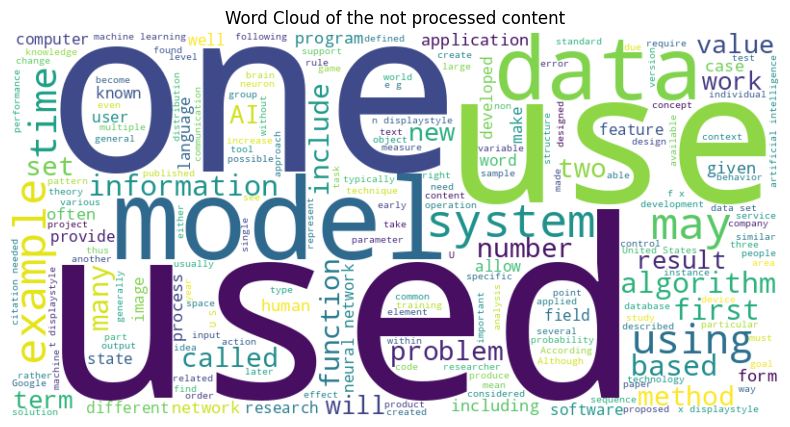

In [108]:
plot_word_cloud(df['content'], 'Word Cloud of the not processed content')

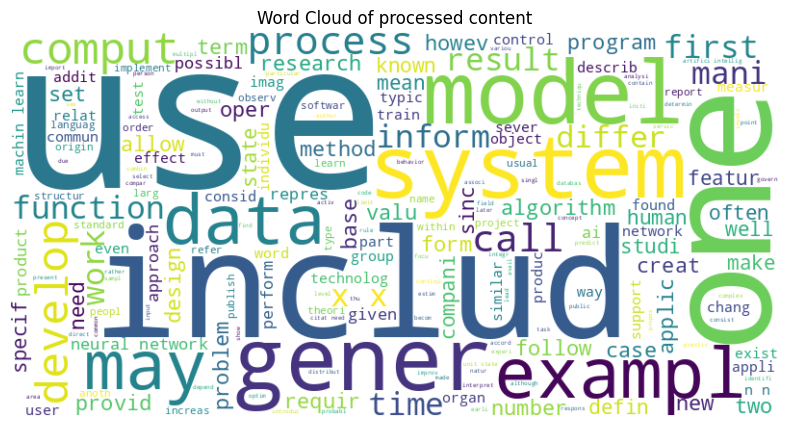

In [107]:
plot_word_cloud(df['processedContent'], name='Word Cloud of processed content')

-----------

### <b>Term Frequency-Inverse Document Frequency Vectorization</b>
In this part, we transform the preprocessed articles into numerical vectors using TF-IDF vectorization, that is Term Frequency-Inverse Document Frequency. <br><br>
TF-IDF is a weighting scheme that is the best konown and most commonly used in the Information Retrieval field.<br>
It quantifies the importance of a term in specific document or like in this case article relative to its importance in the entire corpus.<br><br>
TF-IDF is composed of two parts:
- Term Frequency (TF): Measures how frequently given term appears in the document or articte,
- Inverse Domain Frequency (IDF): It reduces the importance of commonly occuring terms across the whole corpus and at the same time emphasizing the ones that are distinctive.

In [47]:
def tf_idf(df):
    tfidf = TfidfVectorizer(use_idf=True, smooth_idf=False)
    tfidf_matrix = tfidf.fit_transform(df['processedContent'])

    dfTFIDF = pd.DataFrame(tfidf_matrix.toarray(), index=df['title'], columns=tfidf.get_feature_names_out())
    return tfidf, dfTFIDF


Note tht when we display now the dataframe tfidf it may have some 'weird' terms, but actually it is completely ok since they are valid terms (some after preprocessing) from the articles :) <br>(Yes I have checked, 'aaababbbbaab' comes from Formal language article on Wikipedia)

In [48]:
tfidf, dfTFIDF = tf_idf(df)

dfTFIDF.head()

,aa,aaa,aaababbbbaab,aaagtctgac,aaai,aachen,aacl,aacsb,aad,aadhaar,...,積脊跡,精神,纽约时报中文,胡同,自由,良心,蝴蝶,賦有,關係,高尔夫
title,,,,,,,,,,,,,,,,,,,,,
Machine learning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Machine Learning (journal),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Statistical learning in language acquisition,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Data mining,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Supervised learning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


------

## <b>Recommendation System</b> 
This section is  the `core` part of the recommendation system.<br>
It uses all the methods defined and explained above, that is:  
1. <b>Crawling</b>: to get the database of the articles avileable for recomendation, 
2. <b>Processing</b> of the article's content to work with the meaningful text, 
3. <b>TF-IDF vectorization</b> to get the importance of each term artice wise.<br><br>

#### How it works
The recommendation system takes the user's history (a list of titles the user has read or liked) and the article database (our csv file) as input and outputs the top_n (we have chose 5) recommendations – the articles most similar to the user's history.<br><br>
To get the most meaningful recommendations, recommender uses the cosine similarity.<br>
It measures the angle between two vectors in high dimentional space; a smaller angle, that is closer to 1, means higher similarity.
<br><br>
The system fetches content of the articles that are in the user's history from the articles database and transforms it to a vector representation using the TF-IDF vectorization. Next it calculates the cosine similarity between the history vector and each of the articles in the database and returns the ones that are mostly similiar to the user's history, at the same time ensuring that no article from it will be in the recommendations.<br><br>
The output has top_n rows corresponding to the top_n recommendations - the most similiar articles to the user's history, and 3 columns representing article's:
- Title,
- Link - a clickable link that redirects us directly to the recommended article so that it is conveniant for the user and for us to actually go tot the recommended article and not copy and paste it :) (note that the url might differ from the article name, but on the Wikipedia website the article corresponds to the title),
- Similarity score between given article and user's history.

In [49]:
def recommendArticles(history, df, top_n=5):
    
    if df.index.name != 'title': # we set the title as the index
        df = df.set_index('title')
    
    tfidf, dfTFIDF = tf_idf(df.reset_index()) #getting tfidf defined above for the df

    
    
    historyContent = ' '.join(df.loc[history,'processedContent']) #getting the content of the articles in the history
    historyVector = tfidf.transform([historyContent]).toarray()[0] #transforming the content into a vector using tfidf
    
    cosineDistance = dfTFIDF.apply(lambda row: cosine(row, historyVector), axis=1) #calculating cosine distance between the history vector and the articles
    similarityScores = 1 - cosineDistance #calculating similarity scores
    
    
    # we create a dataframe with the title, link and similarity scores
    recommendations = pd.DataFrame({
        'title': dfTFIDF.index, 
        'link': df['link'],
        'similarity': similarityScores
    })
    
    # we exclude the articles that user have already seen from the recommendations
    recommendations = recommendations[~recommendations['title'].isin(history)]
    
    # we sort the recommendations by similarity and get the top_n
    recommendations = recommendations.sort_values(by='similarity', ascending=False).reset_index(drop=True)
    
    # displaying top_n recommendations
    recommendations = recommendations.head(top_n)

    
    # making the links clickable inside the dataframe
    recommendations = HTML(recommendations.to_html(render_links=True, escape=False))
    print(f"Number of considered articles to get the recommendations: {len(df)}")
    
    return recommendations

Now when we have created our recommendation system, we may start testing it. <br>
We have to give the system a list named history, filled with at least one name of the article that based on which we want to create recommendations for the user.

In [50]:
history = ['Machine learning']

recommendations = recommendArticles(history, df, top_n=5)
recommendations

Number of considered articles to get the recommendations: 1000


,title,link,similarity
0,Outline of machine learning,https://en.wikipedia.org/wiki/Outline_of_machine_learning,0.642366
1,Meta-learning (computer science),https://en.wikipedia.org/wiki/Meta-learning_(computer_science),0.592653
2,Neural network (machine learning),https://en.wikipedia.org/wiki/Artificial_neural_network,0.534939
3,Neural network (machine learning),https://en.wikipedia.org/wiki/Neural_network_(machine_learning),0.534939
4,Deep learning,https://en.wikipedia.org/wiki/Deep_neural_network,0.529459


In [51]:
history = ['Machine learning', 'Supervised learning']

recommendations = recommendArticles(history, df, top_n=5)
recommendations

Number of considered articles to get the recommendations: 1000


,title,link,similarity
0,Outline of machine learning,https://en.wikipedia.org/wiki/Outline_of_machine_learning,0.627044
1,Meta-learning (computer science),https://en.wikipedia.org/wiki/Meta-learning_(computer_science),0.613893
2,Self-supervised learning,https://en.wikipedia.org/wiki/Self-supervised_learning,0.535426
3,Neural network (machine learning),https://en.wikipedia.org/wiki/Artificial_neural_network,0.530469
4,Neural network (machine learning),https://en.wikipedia.org/wiki/Neural_network_(machine_learning),0.530469


In [ ]:
history = ['Machine learning', 'Supervised learning', 'Self-supervised learning', 'Formal language']

recommendations = recommendArticles(history, df, top_n=5)
recommendations

----------------

### <b>Adding articles in user history that are not in the database</b>
Since the Wikipedia has more than 6 million English articles we may encounter the situation that the user has seen the article that is not in our rather small database; <br>
To addres this, we implemented a dynamic mechanism to handle such cases by fetching, processing, and expanding the database with new articles.
#### Steps for adding a new article
1. Fetch Article:<br>
The fetchUnknownArticle function takes the title of the unknown article as input. It constructs the article's URL using the Wikipedia structure and fetches its content by making an HTTP request.
    - The function extracts the title, link, and content of the article.
    - The content is processed using the preprocessArticles function to generate a processedContent field.

2. Looking for new related articles <br>
The additionalArticles function is invoked for the newly fetched article. This function uses the article's link as the starting point for crawling additional related articles.<br>
It's main purpose is to ensure that we would get some meaningful recommendations, because if we at first have the database created by crawling that was started from the Machine Learning and user in their history would only have articles on flowers then the similarities would be really small and not so meaningful.

    - Newly crawled articles are filtered to ensure they aren't already in the database.
    - Each article is processed (it should be processed the same way that our database was) and added to the list of new articles.

3. Update the Database
The expandDatabase function consolidates the newly fetched articles (both the original and the crawled ones) and appends them to the existing database.

    - The database is updated dynamically to include these new articles, ensuring no duplicates are introduced.
    

----

### When the recommendation system is invoked:

The user's history is examined to identify titles that are missing from the database.
Missing articles are fetched, processed, and added to the database through the steps above.
The expanded database is then used to generate recommendations, ensuring the system remains robust and comprehensive, even with articles outside the original dataset.

----------------

### Explanations
Additionaly in here we have added the explanations<br>
It was done to enhance th user's (and ours) understanding of recommendations. This gives us the top three terms in for each recommended article that have contributed the most to its similarity score.<br>
For each recommended article, its vector representation (tfidf vectorization) is analyzed to get the terms that have the highest tf-idf scores. <br>
Our explanation focuses on terms that are either directly related to user's history or are highly relevant based on their importance in the recommended article. 


In [52]:
# history = ['Machine learning', 'Aliens']
# recommendations = recommendArticles(history, df, top_n=5)
# recommendations

In [75]:
df = pd.read_csv('processedArticles.csv')

In [89]:
def fetchUnknownArticle(unknowTitle):
    base_url = "https://en.wikipedia.org/wiki/"
    url = base_url + unknowTitle.replace(' ', '_') # we replace the spaces with underscores since this is how the URLs are formatted in Wiki
    
    try:
        response = requests.get(url) # geting the page
        response.raise_for_status() # raise an exception if the status is not 200
        soup = BeautifulSoup(response.content, 'html.parser') # parsing the page
        
        paragraphs = soup.find_all('p') # article's paragraphs
        content = ' '.join([p.text for p in paragraphs if p.text]) # article's content that is inside paragraphs
        
        #to preprocess the content we simulate dataframe row
        row = pd.Series({"content": content})
        
        processedArticle = preprocessArticles(row, tokenizer=word_tokenize, stemmer=porter, 
                                                          lemmatizer=None, useLemmatizer=False)
        
        
        # we create a dictionary with the title, link and processed content
        newArticle = {"title": unknowTitle, "link": url, "content": content, 
                      "processedContent": processedArticle}
        return newArticle
    except:
        print(f"Failed to fetch article {unknowTitle}. Please check the title and try again.")

In [78]:
def additionalArticles(newArticle, df, maxExpansion=50):
    mainArticle = fetchUnknownArticle(newArticle) #fetching the main article taht is missing in the database but is in user's history
    if mainArticle is None: 
        return []
    
    # expansionNumber = random.randint(5, maxExpansion)
    # we perform the crawling to get some meaningful and somehow connected articles to the unknown one from the user's history
    newCrawledArticles = crawlArticles(mainArticle['link'], max_articles=maxExpansion)
    
    processedNewArticles=[]
    for article in newCrawledArticles:
        if article['title'] not in df.index:
            row = pd.Series({"content": article['content']})
            # we preprocess the content of the new articles same way as the df!
            article['processedContent'] = preprocessArticles(row, tokenizer=word_tokenize, stemmer=porter, 
                                                          lemmatizer=None, useLemmatizer=False)
            processedNewArticles.append(article)
            
    return processedNewArticles

In [79]:
def expandDatabase(history, df):
    # wee look for the titles that are in the history but not in the database
    unknownTitles = [title for title in history if title not in df.index]
    allNewArticles = []
    
    for title in unknownTitles:
        # if there is an unknown article, we fetch it and crawl some additional articles using functions above
        articleData = fetchUnknownArticle(title)
        if articleData:
            allNewArticles.append(articleData)
            crawledArticles = additionalArticles(title, df)
            allNewArticles.extend(crawledArticles)
            
    if allNewArticles:
        additionaldf = pd.DataFrame(allNewArticles).set_index('title') 
        additionaldf = additionaldf[~additionaldf.index.duplicated(keep='first')] # we remove duplicates from the new articles
        df = pd.concat([df, additionaldf]) # we concatenate the new articles with the existing database
        df = df[~df.duplicated(subset='link', keep='first')] #  duplicatremovinges based on the link
        # saveDatabase(df, 'processedArticles.csv')
    else:
        print("No new articles found.")
    print(f"Number of articles in the database after expansion: {len(df)}")
    return df
        

-------

## <b>New recommender system</b>
So now we changed a little bit the previos reccomendation system so that it incorporates the new ideas:
- looking for recommendations of articles not present in the database,
- getting some 'related' articles to the unknown one to get the meaningful and useful recommendations, 
- explanations to the recommended articles
<br><br>


In [80]:
def recommendArticles(history, df, top_n=5, explanation_terms=3):
    
    if df.index.name != 'title':
        df = df.set_index('title')
    
    # expanding the database, so checking if there are missing articles in df that are in the history, fetchin them and crawling 
    df = expandDatabase(history, df)
    # print(f"Number of considered articles to get the recommendations: {len(df)}")
    

    
    tfidf, dfTFIDF = tf_idf(df.reset_index())
    
    historyContent = ' '.join(df.loc[history,'processedContent']) #getting the content of the articles in the history 
    historyVector = tfidf.transform([historyContent]).toarray()[0] #transforming the content into a vector using tfidf
    
    cosineDistance = dfTFIDF.apply(lambda row: cosine(row, historyVector), axis=1) #calculating cosine distance between the history vector and the articles
    similarityScores = 1 - cosineDistance #calculating similarity scores
    
    # we create a dataframe with the title, link and similarity scores
    recommendations = pd.DataFrame({
        'title': dfTFIDF.index, 
        'link': df['link'],
        'similarity': similarityScores
    })
    
    # we exclude the articles that user have already seen from the recommendations
    recommendations = recommendations[~recommendations['title'].isin(history)]
    
    recommendations = recommendations.sort_values(by='similarity', ascending=False).reset_index(drop=True)   
    
    
    #we select the top_n recommendations
    recommendations = recommendations.head(top_n)

    # Now we will provide explanations for the recommendations
    feature_names = tfidf.get_feature_names_out() # Get the feature names from the TF-IDF vectorizer
    explanations = []
    for _, row in recommendations.iterrows(): # Iterate over the recommendations
        article_vector = dfTFIDF.loc[row['title']].values # Get the TF-IDF vector for the article
        article_vector_array = np.array(article_vector)  

        # we get the indices of the top explanation_terms terms in the article vector
        top_terms_indices = np.argsort(article_vector_array)[-explanation_terms:][::-1]
    
        # Eensuring that term is properly indexed and converted to strings
        top_terms = [str(feature_names[i]) for i in top_terms_indices]

        explanations.append(", ".join(top_terms) if top_terms else "No meaningful terms")

    recommendations['explanation'] = explanations
    
    recommendations = HTML(recommendations.to_html(render_links=True, escape=False))
    
    
    return recommendations

In [81]:
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# # Most Frequent Words
# def plot_most_frequent_words(df, top_n=20):
#     all_words = ' '.join(df['processedContent']).split()
#     word_counts = pd.Series(all_words).value_counts().head(top_n)
#     word_counts.plot(kind='bar', figsize=(10, 6), title='Most Frequent Words')
#     plt.xlabel('Words')
#     plt.ylabel('Frequency')
#     plt.show()

# # Word Cloud
# def plot_word_cloud(df):
#     all_words = ' '.join(df['processedContent'])
#     wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.title('Word Cloud of Processed Content')
#     plt.show()

# # Article Length Distribution
# def plot_article_length_distribution(df):
#     article_lengths = df['processedContent'].apply(lambda x: len(x.split()))
#     article_lengths.plot(kind='hist', bins=20, figsize=(10, 6), title='Article Length Distribution')
#     plt.xlabel('Number of Words')
#     plt.ylabel('Number of Articles')
#     plt.show()

# # Generate statistics
# plot_most_frequent_words(df)
# plot_word_cloud(df)
# plot_article_length_distribution(df)


# Testing

In [ ]:
history = ['Machine learning', 'Extraterrestrial life', 'Adolf Hitler']
recommendations = recommendArticles(history, df, top_n=5)
print(f"Recommendations based on articles {history}:")
recommendations


Number of articles in the database after expansion: 1098
Number of considered articles to get the recommendations: 1098
Recommendations based on articles ['Machine learning', 'Extraterrestrial life', 'Adolf Hitler']:


,title,link,similarity,explanation
0,Political views of Adolf Hitler,https://en.wikipedia.org/wiki/Political_views_of_Adolf_Hitler,0.741777,"hitler, nazi, mein"
1,Military career of Adolf Hitler,https://en.wikipedia.org/wiki/Military_career_of_Adolf_Hitler,0.665421,"hitler, regiment, war"
2,Health of Adolf Hitler,https://en.wikipedia.org/wiki/Health_of_Adolf_Hitler,0.657811,"hitler, morel, kersten"
3,Death of Adolf Hitler,https://en.wikipedia.org/wiki/Death_of_Adolf_Hitler,0.657646,"hitler, soviet, braun"
4,Religious views of Adolf Hitler,https://en.wikipedia.org/wiki/Religious_views_of_Adolf_Hitler,0.646533,"hitler, christian, church"


In [83]:
history = ['Supervised learning', 'Unsupervised learning']
recommendations = recommendArticles(history, df, top_n=5)
recommendations

No new articles found.
Number of articles in the database after expansion: 1000
Number of considered articles to get the recommendations: 1000


,title,link,similarity,explanation
0,Machine learning,https://en.wikipedia.org/wiki/Machine_learning,0.626917,"learn, machin, data"
1,Meta-learning (computer science),https://en.wikipedia.org/wiki/Meta-learning_(computer_science),0.492054,"learn, algorithm, network"
2,Self-supervised learning,https://en.wikipedia.org/wiki/Self-supervised_learning,0.486766,"learn, ncssl, ssl"
3,Outline of machine learning,https://en.wikipedia.org/wiki/Outline_of_machine_learning,0.466568,"learn, ml, machin"
4,Feature learning,https://en.wikipedia.org/wiki/Feature_learning,0.463154,"represent, data, learn"


In [84]:
history = ['Machine learning', 'Memtransistor', 'Train', 'Germany']
recommendations = recommendArticles(history, df, top_n=5)
recommendations

Number of articles in the database after expansion: 1099
Number of considered articles to get the recommendations: 1099


,title,link,similarity,explanation
0,Demographics of Germany,https://en.wikipedia.org/wiki/Demographics_of_Germany,0.551790,"germani, german, immigr"
1,West Germany,https://en.wikipedia.org/wiki/West_Germany,0.542116,"germani, west, german"
2,Germans,https://en.wikipedia.org/wiki/Germans,0.463605,"german, germani, roman"
3,Rail transport,https://en.wikipedia.org/wiki/Rail_transport,0.449520,"rail, railway, locomot"
4,Rail transport in Germany,https://en.wikipedia.org/wiki/Rail_transport_in_Germany,0.431968,"railway, germani, db"


In [85]:
history = ['Memtransistor', 'Train', 'Germany', 'Machine learning']
recommendations = recommendArticles(history, df, top_n=5)
recommendations

Number of articles in the database after expansion: 1099
Number of considered articles to get the recommendations: 1099


,title,link,similarity,explanation
0,Demographics of Germany,https://en.wikipedia.org/wiki/Demographics_of_Germany,0.551790,"germani, german, immigr"
1,West Germany,https://en.wikipedia.org/wiki/West_Germany,0.542116,"germani, west, german"
2,Germans,https://en.wikipedia.org/wiki/Germans,0.463605,"german, germani, roman"
3,Rail transport,https://en.wikipedia.org/wiki/Rail_transport,0.449520,"rail, railway, locomot"
4,Rail transport in Germany,https://en.wikipedia.org/wiki/Rail_transport_in_Germany,0.431968,"railway, germani, db"


In [86]:
history = ['Mountain pigeon']
recommendations = recommendArticles(history, df, top_n=5)
recommendations

Number of articles in the database after expansion: 1049
Number of considered articles to get the recommendations: 1049


,title,link,similarity,explanation
0,Buru mountain pigeon,https://en.wikipedia.org/wiki/Buru_mountain_pigeon,0.841057,"pigeon, buru, mountain"
1,Papuan mountain pigeon,https://en.wikipedia.org/wiki/Papuan_mountain_pigeon,0.831227,"pigeon, papuan, mountain"
2,Seram mountain pigeon,https://en.wikipedia.org/wiki/Seram_mountain_pigeon,0.781285,"pigeon, seram, mountain"
3,Pale mountain pigeon,https://en.wikipedia.org/wiki/Pale_mountain_pigeon,0.741922,"pigeon, pale, mountain"
4,Imperial pigeon,https://en.wikipedia.org/wiki/Imperial_pigeon,0.537598,"pigeon, ducula, imperi"


In [87]:
history = ['Papuan mountain pigeon']
recommendations = recommendArticles(history, df, top_n=5)
recommendations

Number of articles in the database after expansion: 1047
Number of considered articles to get the recommendations: 1047


,title,link,similarity,explanation
0,Mountain pigeon,https://en.wikipedia.org/wiki/Mountain_pigeon,0.835399,"pigeon, mountain, buru"
1,Bare-eyed pigeon,https://en.wikipedia.org/wiki/Patagioenas_corensis,0.492964,"pigeon, picazuro, corensi"
2,Topknot pigeon,https://en.wikipedia.org/wiki/Lopholaimus,0.465529,"pigeon, topknot, fruit"
3,Columbidae,https://en.wikipedia.org/wiki/Columbidae,0.391664,"dove, pigeon, speci"
4,Hemiphaga,https://en.wikipedia.org/wiki/Hemiphaga,0.330187,"hemiphaga, pigeon, genu"


In [88]:
df

,title,link,content,processedContent
0,Machine learning,https://en.wikipedia.org/wiki/Machine_learning,Machine learning (ML) is a field of study in a...,machin learn ml field studi artifici intellig ...
1,Machine Learning (journal),https://en.wikipedia.org/wiki/Machine_Learning...,Machine Learning is a peer-reviewed scientifi...,machin learn scientif journal publish sinc for...
2,Statistical learning in language acquisition,https://en.wikipedia.org/wiki/Statistical_lear...,Statistical learning is the ability for humans...,statist learn abil human anim extract statist ...
3,Data mining,https://en.wikipedia.org/wiki/Data_mining,Data mining is the process of extracting and d...,data mine process extract discov pattern larg ...
4,Supervised learning,https://en.wikipedia.org/wiki/Supervised_learning,"In machine learning, supervised learning (SL) ...",machin learn supervis learn sl paradigm model ...
...,...,...,...,...
995,Limitations and exceptions to copyright,https://en.wikipedia.org/wiki/Limitations_and_...,\n Limitations and exceptions to copyright are...,limit except copyright provis local copyright ...
996,Copyright and Information Society Directive 2001,https://en.wikipedia.org/wiki/Information_Soci...,\n The Copyright and Information Society Direc...,copyright inform societi direct direct europea...
997,European Commission,https://en.wikipedia.org/wiki/European_Commission,\n The European Commission (EC) is the primary...,european commiss ec primari execut arm europea...
998,Open access,https://en.wikipedia.org/wiki/Open_access,\n Open access (OA) is a set of principles and...,open access oa set principl rang practic nomin...
